## Multibox_pior

In [1]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[1:3]
    # print(in_height, in_width)
    num_sizes, num_ratios = len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = np.array(sizes, dtype=np.float32)
    ratio_tensor = np.array(ratios, dtype=np.float32)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y-axis
    steps_w = 1.0 / in_width  # Scaled steps in x-axis
#     print(steps_h.dtype)

    # Generate all center points for the anchor boxes
    center_h = (np.arange(in_height, dtype=np.float32) + offset_h) * steps_h
    center_w = (np.arange(in_width, dtype=np.float32) + offset_w) * steps_w
    shift_x, shift_y = np.meshgrid(center_w, center_h)
    shift_x, shift_y = shift_x.reshape(-1), shift_y.reshape(-1)


    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = np.concatenate((size_tensor * np.sqrt(ratio_tensor[0], dtype=np.float32),
                        sizes[0] * np.sqrt(ratio_tensor[1:], dtype=np.float32))) \
                        * in_height / in_width  # Handle rectangular inputs
    h = np.concatenate((size_tensor / np.sqrt(ratio_tensor[0], dtype=np.float32),
                        sizes[0] / np.sqrt(ratio_tensor[1:], dtype=np.float32)))
    # Divide by 2 to get half height and half width
    anchor_manipulations = np.tile(
        np.stack((-w, -h, w, h)).T, (in_height * in_width, 1)) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = np.stack([shift_x, shift_y, shift_x, shift_y],
                        axis=1).repeat(boxes_per_pixel, axis=0)
    output = out_grid + anchor_manipulations
    return np.expand_dims(output, axis=0)

## Bbox_to_rect

In [2]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0],
                             height=bbox[3] - bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

## Box_corner_to_center

In [3]:
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = np.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = np.stack((x1, y1, x2, y2), axis=-1)
    return boxes

## box_iou

In [4]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = np.maximum(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = np.minimum(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clip(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## Assign_anchor_to_bbox

In [5]:
def assign_anchor_to_bbox(ground_truth, anchors, device=None, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = np.full((num_anchors,), -1, dtype=np.int32)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = np.max(jaccard, axis=1), np.argmax(jaccard, axis=1)
    anc_i = np.nonzero(max_ious >= 0.5)[0]
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = np.full((num_anchors,), -1)
    row_discard = np.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = np.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).astype('int32')
        anc_idx = (max_idx / num_gt_boxes).astype('int32')
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

## Offset_boxes

In [6]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * np.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = np.concatenate([offset_xy, offset_wh], axis=1)
    return offset

## multibox_target

In [7]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)
                                                 
        bbox_mask = np.tile((np.expand_dims(
            (anchors_bbox_map >= 0), axis=-1)), (1, 4)).astype('float32')
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = np.zeros(num_anchors, dtype=np.int32)
        assigned_bb = np.zeros((num_anchors, 4), dtype=np.float32,)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = np.nonzero(anchors_bbox_map >= 0)[0]
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].astype('float32') + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels.astype('float32'))
    
    bbox_offset = np.stack(batch_offset)
    bbox_mask = np.stack(batch_mask)
    # print(class_labels.dtype)
    class_labels = np.stack(batch_class_labels)
    
    return (bbox_offset, bbox_mask, class_labels)

## Offset_inverse

In [8]:
def offset_inverse(anchors, offset_preds):
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = np.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = np.concatenate((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

## nms

In [9]:
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = scores.argsort()[::-1]
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.size > 0:
        i = B[0]
        keep.append(i)
        if B.size == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = np.nonzero(iou <= iou_threshold)[0]
        B = B[inds + 1]
    return np.array(keep, dtype=np.int32)

## multibox_detection

In [10]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    batch_size = cls_probs.shape[0]
    anchors = np.squeeze(anchors, axis=0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = np.max(cls_prob[1:], 0), np.argmax(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = np.arange(num_anchors, dtype=np.int32)
        combined = np.concatenate((keep, all_idx))
        unique, counts = np.unique(combined, return_counts=True)
        non_keep = unique[counts == 1]
        all_id_sorted = np.concatenate((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted].astype('float32')
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = np.concatenate((np.expand_dims(
            class_id, axis=1), np.expand_dims(conf, axis=1), predicted_bb),
                                   axis=1)
        out.append(pred_info)
    return np.stack(out)

In [11]:
# import hashlib
# import os
# import tarfile
# import zipfile
# import requests

# #@save
# DATA_HUB = dict()
# DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [12]:
# def download_extract(name, folder=None):  #@save
#     """Download and extract a zip/tar file."""
#     fname = download(name)
#     base_dir = os.path.dirname(fname)
#     data_dir, ext = os.path.splitext(fname)
#     if ext == '.zip':
#         fp = zipfile.ZipFile(fname, 'r')
#     elif ext in ('.tar', '.gz'):
#         fp = tarfile.open(fname, 'r')
#     else:
#         assert False, 'Only zip/tar files can be extracted.'
#     fp.extractall(base_dir)
#     return os.path.join(base_dir, folder) if folder else data_dir

# def download_all():  #@save
#     """Download all files in the DATA_HUB."""
#     for name in DATA_HUB:
#         download(name)

In [13]:
# def download(name, cache_dir=os.path.join('..', 'data')):  #@save
#     """Download a file inserted into DATA_HUB, return the local filename."""
#     assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
#     url, sha1_hash = DATA_HUB[name]
#     os.makedirs(cache_dir, exist_ok=True)
#     fname = os.path.join(cache_dir, url.split('/')[-1])
#     if os.path.exists(fname):
#         sha1 = hashlib.sha1()
#         with open(fname, 'rb') as f:
#             while True:
#                 data = f.read(1048576)
#                 if not data:
#                     break
#                 sha1.update(data)
#         if sha1.hexdigest() == sha1_hash:
#             return fname  # Hit cache
#     print(f'Downloading {fname} from {url}...')
#     r = requests.get(url, stream=True, verify=True)
#     with open(fname, 'wb') as f:
#         f.write(r.content)
#     return fname

In [14]:
# %matplotlib inline
# import os
# import pandas as pd


# #@save
# DATA_HUB['banana-detection'] = (
#     DATA_URL + 'banana-detection.zip',
#     '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [15]:
# #@save
# def read_data_bananas(is_train=True):
#     """Read the banana detection dataset images and labels."""
#     data_dir = download_extract('banana-detection')
#     csv_fname = os.path.join(data_dir,
#                              'bananas_train' if is_train else 'bananas_val',
#                              'label.csv')
#     csv_data = pd.read_csv(csv_fname)
#     csv_data = csv_data.set_index('img_name')
#     images, targets = [], []
#     for img_name, target in csv_data.iterrows():
#         images.append(
#             plt.imread(
#                 os.path.join(data_dir,
#                              'bananas_train' if is_train else 'bananas_val',
#                              'images', f'{img_name}')))
#         # Here `target` contains (class, upper-left x, upper-left y,
#         # lower-right x, lower-right y), where all the images have the same
#         # banana class (index 0)
#         targets.append(list(target))
#     return images, np.expand_dims(np.array(targets), 1) / 256

In [16]:
# import numpy as np
# from tensorflow.keras.utils import Sequence, to_categorical
# import cv2

# class DataGenerator(Sequence):
#     'Generates data for Keras'
#     def __init__(self,
#                  batch_size, is_train,
#                  shuffle=True):
#         '''
#         all_filenames: list toàn bộ các filename
#         labels: nhãn của toàn bộ các file
#         batch_size: kích thước của 1 batch
#         index2class: index của các class
#         input_dim: (width, height) đầu vào của ảnh
#         n_channels: số lượng channels của ảnh
#         n_classes: số lượng các class 
#         shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
#         '''
#         self.features, self.labels = read_data_bananas(is_train)
#         print('read ' + str(len(self.features)) + (
#             f' training examples' if is_train else f' validation examples'))
#         self.batch_size = batch_size
        
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         '''
#         return:
#           Trả về số lượng batch/1 epoch
#         '''
#         return int(np.floor(len(self.features) / self.batch_size))

#     def __getitem__(self, index):
#         '''
#         params:
#           index: index của batch
#         return:
#           X, y cho batch thứ index
#         '''
#         # Lấy ra indexes của batch thứ index
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # List all_filenames trong một batch
#         all_features = [self.features[k] for k in indexes]
#         all_labels = [self.labels[k] for k in indexes]
        
#         all_features = np.asarray(all_features).astype(np.float32)
#         all_labels = np.asarray(all_labels).astype(np.float32)
        
        
        

#         # Khởi tạo data
# #         X, y = self.__data_generation(all_features, all_labels)

#         return all_features, all_labels

#     def on_epoch_end(self):
#         '''
#         Shuffle dữ liệu khi epochs end hoặc start.
#         '''
#         self.indexes = np.arange(len(self.features))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, all_features, all_labels):
#         '''
#         params:
#           all_filenames_temp: list các filenames trong 1 batch
#         return:
#           Trả về giá trị cho một batch.
#         '''
#         X = np.empty((self.batch_size, 256,256, 3), dtype=np.float32)
#         y = np.empty((self.batch_size, 1, 5), dtype=np.float32)

#         # Khởi tạo dữ liệu
#         for i, fn in enumerate(all_features, all_labels):
#             # Đọc file từ folder name
#             img = all_features.astype('float32')
# #             label = 

#             label = fn.split('/')[3]
#             label = self.index2class[label]
    
#             X[i,] = img

#             # Lưu class
#             y[i] = label
#         return X, y

In [17]:
# def load_data_bananas(batch_size):
#     """Load the banana detection dataset."""
#     train_iter = DataGenerator(batch_size, is_train=True, shuffle=True)
#     val_iter =DataGenerator(batch_size, is_train=False)
#     return train_iter, val_iter

In [18]:
# batch_size, edge_size = 2, 256
# train_iter, _ = load_data_bananas(batch_size)
# batch = next(iter(train_iter))
# batch[0].shape, batch[1].shape

In [19]:
# batch[0].shape, batch[1].shape

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def cls_predictor(num_anchors, num_classes):
    return layers.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding="same")

In [22]:
def bbox_predictor(num_anchors):
    return layers.Conv2D(num_anchors * 4, kernel_size=3, padding="same")

In [23]:

def flatten_pred(pred):
    # print(tf.reshape(pred, shape=(-1,)))
    return tf.reshape(pred, shape=(pred.shape[0], -1))

def concat_preds(preds):
    return tf.concat([flatten_pred(p) for p in preds], axis=1)

In [24]:
def down_sample_blk(num_channels):
    blk = tf.keras.Sequential()
    for _ in range(2):
        blk.add(layers.Conv2D(num_channels, kernel_size=3, padding="same"))
        blk.add(layers.BatchNormalization())
        blk.add(layers.Activation('relu'))

    blk.add(layers.MaxPool2D(2))
    return blk

In [25]:
# def base_net():
#     blk = tf.keras.Sequential()
#     for num_filters in [16, 32, 64]:
#         blk.add(down_sample_blk(num_filters))
#     return blk

# forward(np.zeros((2, 256, 256, 3)), base_net()).shape

In [26]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = layers.GlobalMaxPool2D(keepdims=True)
    else:
        blk = down_sample_blk(128)
    return blk

In [27]:
# def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
#     Y = blk(X)
#     # print(Y.shape, size, ratio)
#     anchors = multibox_prior(Y, sizes=size, ratios=ratio)
#     # print("anchor", anchors.shape)
#     cls_preds = cls_predictor(Y)
#     bbox_preds = bbox_predictor(Y)
#     return (Y, anchors, cls_preds, bbox_preds)

In [28]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

input_tf = np.random.rand(1,256,256,3).astype("float32")

In [29]:







# class TinySSD(tf.keras.Model):
#     def __init__(self, num_classes, **kwargs):
#         super(TinySSD, self).__init__(**kwargs)
#         self.num_classes = num_classes
#         # for i in range(5):
#         #     # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
#         #     setattr(self, f'blk_{i}', get_blk(i))
#         #     setattr(self, f'cls_{i}', cls_predictor(num_anchors, num_classes))
#         #     setattr(self, f'bbox_{i}', bbox_predictor(num_anchors))
#         self.blk = get_blk(0)
#         self.cls = cls_predictor(4,1)
#         self.bbox = bbox_predictor(4)

#     def call(self, X):
        
#         # X = self.blk(X)
        
#         X, anchors, cls_preds, bbox_preds = blk_forward(X, self.blk,  sizes[0], ratios[0], self.cls, self.bbox)
        
#         print( anchors.shape, cls_preds.shape, bbox_preds.shape)
        
#         # print(X.shape)
#         # anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
#         # for i in range(5):
#         #     # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
#         #     # print(X.shape)
#         #     X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
#         #         X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
#         #         getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
#         #     # print(X.shape)
#         #     # print(anchors[i].shape)
#         # # print(anchors.shape)
#         # anchors = np.concatenate(anchors, axis=1)
#         # cls_preds = concat_preds(cls_preds)
#         cls_preds = tf.reshape(cls_preds, (cls_preds.shape[0], -1,self.num_classes + 1))
#         print(bbox_preds.shape)
#         bbox_preds = concat_preds([bbox_preds])
#         return anchors, cls_preds, bbox_preds
#         print(X.shape)
#         # return X, _, _

In [30]:

class Block_tf(tf.keras.Model):
    """Create Block convlution for Encode. Use layers convlution

    Args:
        torch ([Module pytorch]): [create block conv with class Module of pytorch]
    """
    def __init__(self, mid_channel, out_channels, batch_norm=False):
        super().__init__()
        
        self.conv1 = layers.Conv2D(mid_channel, kernel_size=3, padding='same')
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, padding='same')
        
        self.batch_norm = batch_norm
        if batch_norm:
            self.bn1 = layers.BatchNormalization()
            self.bn2 = layers.BatchNormalization()
            
    def call(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = tf.nn.relu(x)
        
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        out = tf.nn.relu(x)
        return out

    @property
    def _get_conv(self):
        name_layer = ["conv1", "conv2"]
        
        # [getattr(self, i) for i in name_layer]
        
        return [getattr(self, i) for i in name_layer]


In [31]:
class MySSD_tf(tf.keras.Model):
    def down(self, x):
        return layers.MaxPool2D(2)(x)
    def __init__(self, num_classes=None, batch_norm=False, upscale_mode="nearest"):
        super().__init__()

        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        self.sizes = [[0.2, 0.272], [0.37, 0.447], 
                        [0.54, 0.619], [0.71, 0.79], 
                        [0.88, 0.961]]
        self.ratios = [[1, 2, 0.5]] * 5
        self.num_anchors = [len(size) + len(ratio) - 1 for size, ratio in zip(self.sizes, self.ratios)]

        self.auxiliaryconvs = AuxiliaryConvolutions_tf()
        
        # encoder
        self.enc1 = Block_tf(16, 16, batch_norm)
        self.enc2 = Block_tf(32, 32, batch_norm)
        self.enc3 = Block_tf(64, 64, batch_norm)
        self.enc4 = Block_tf(128, 128, batch_norm)
        
        self.num_classes = num_classes
        idx_to_in_channels = [128, 128, 128, 128, 128]
        for i in range(len(idx_to_in_channels)):
            setattr(self, f'cls_{i}', cls_predictor(self.num_anchors[i],
                              self.num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(self.num_anchors[i]))
        


    def call(self, x):
        self.anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

        enc1 = self.enc1(x) # 300x300
        enc2 = self.enc2(self.down(enc1)) # 150x150
        enc3 = self.enc3(self.down(enc2)) # 75x75
        enc4 = self.enc4(self.down(enc3)) # 37x37

        enc5, enc6, enc7, enc8 = self.auxiliaryconvs(enc4)

        for i, enc in enumerate([enc4, enc5, enc6, enc7, enc8]):
            
            print(enc.shape)

            anchor = multibox_prior(enc, self.sizes[i], self.ratios[i])
            assert (enc.shape[1]*enc.shape[2]*len(self.sizes[i])+len(self.ratios[i])-1)

            cls_pred = getattr(self, f'cls_{i}')(enc)

            bbox_pred = getattr(self, f'bbox_{i}')(enc)
            self.anchors[i] = anchor
            cls_preds[i] = cls_pred
            bbox_preds[i] = bbox_pred

        self.anchors = tf.concat(self.anchors, axis=1)

        cls_preds = concat_preds(cls_preds)

        cls_preds = tf.reshape(cls_preds, (cls_preds.shape[0], -1,
                                      self.num_classes + 1))
        bbox_preds = concat_preds(bbox_preds)

        assert cls_preds.shape[2] == self.num_classes + 1
        assert self.anchors.shape[1] == cls_preds.shape[1] == int(bbox_preds.shape[1]/4)
        return [self.anchors, cls_preds, bbox_preds]

    @property
    def _get_conv_block(self):
        name_layer = ["enc1", "enc2", "enc3", "enc4"]
        return [getattr(self, i) for i in name_layer]

    @property
    def _get_cls(self):
        name_layer = ["cls_0", "cls_1", "cls_2", "cls_3", "cls_4"]
        return [getattr(self, i) for i in name_layer]

    @property
    def _get_bbox(self):
        name_layer = ["bbox_0", "bbox_1", "bbox_2", "bbox_3", "bbox_4"]
        return [getattr(self, i) for i in name_layer]

    @property
    def _get_auxiliaryconv(self):
        name_layer = ["auxiliaryconvs"]
        return [getattr(self, i) for i in name_layer]


In [32]:

class AuxiliaryConvolutions_tf(tf.keras.Model):

    def __init__(self):
        super(AuxiliaryConvolutions_tf, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv1_1 = layers.Conv2D(128, kernel_size=1)  # stride = 1, by default
        self.conv1_2 = layers.Conv2D(128, kernel_size=3, strides=2)  # dim. reduction because stride > 1

        self.conv2_1 = layers.Conv2D(128, kernel_size=1)
        self.conv2_2 = layers.Conv2D(128, kernel_size=3, strides=2)  # dim. reduction because stride > 1

        self.conv3_1 = layers.Conv2D(128, kernel_size=1, )
        self.conv3_2 = layers.Conv2D(128, kernel_size=3, strides=2)  # dim. reduction because padding = 0

        self.conv4_1 = layers.Conv2D(128, kernel_size=1)
        self.conv4_2 = layers.Conv2D(128, kernel_size=3)  # dim. reduction because padding = 0

    def call(self, conv4):
 
        # print(conv7_feats.shape)
        out = tf.nn.relu(self.conv1_1(conv4))  # (N, 128, 37, 37)
        out = tf.nn.relu(self.conv1_2(out))  # (N, 128, 18, 18)
        # print(out.shape)
        conv1_2_feats = out  # (N, 128, 10, 10)
        

        out = tf.nn.relu(self.conv2_1(out))  # (N, 128, 18, 18)
        out = tf.nn.relu(self.conv2_2(out))  # (N, 128, 9, 9)
        # print(out.shape)
        conv2_2_feats = out  # (N, 128, 5, 5)

        out = tf.nn.relu(self.conv3_1(out))  # (N, 128, 9, 9)
        out = tf.nn.relu(self.conv3_2(out))  # (N, 128, 4, 4)
        # print(out.shape)
        conv3_2_feats = out  # (N, 128, 3, 3)

        out = tf.nn.relu(self.conv4_1(out))  # (N, 128, 4, 4)
        conv4_2_feats = tf.nn.relu(self.conv4_2(out))  # (N, 128, 2, 2)
        # print(conv11_2_feats.shape)

        # Higher-level feature maps
        return conv1_2_feats, conv2_2_feats, conv3_2_feats, conv4_2_feats

    @property
    def _get_conv_anxi(self):
        name_layer = ["conv1_1", "conv1_2", "conv2_1", "conv2_2", 
                        "conv3_1", "conv3_2", "conv4_1", "conv4_2"]
        return [getattr(self, i) for i in name_layer]


In [64]:
model_tf = MySSD_tf(num_classes=1, batch_norm=True)

In [65]:
model_tf(input_tf)

(1, 32, 32, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)
(1, 3, 3, 128)
(1, 1, 1, 128)


[<tf.Tensor: shape=(1, 5232, 4), dtype=float32, numpy=
 array([[[-0.084375  , -0.084375  ,  0.115625  ,  0.115625  ],
         [-0.12037501, -0.12037501,  0.151625  ,  0.151625  ],
         [-0.12579636, -0.05508568,  0.15704636,  0.08633568],
         ...,
         [ 0.01949999,  0.01949999,  0.9805    ,  0.9805    ],
         [-0.12225395,  0.18887302,  1.1222539 ,  0.81112695],
         [ 0.18887302, -0.12225395,  0.81112695,  1.1222539 ]]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5232, 2), dtype=float32, numpy=
 array([[[ 1.5254253 , -0.01976427],
         [-1.7493742 ,  0.47165206],
         [-1.7922426 ,  0.07763925],
         ...,
         [-0.01241772, -0.01175417],
         [-0.003929  ,  0.10603862],
         [ 0.04423066,  0.0122935 ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 20928), dtype=float32, numpy=
 array([[-0.52017164, -1.7269201 ,  1.7430496 , ...,  0.09843475,
          0.05282429, -0.01272492]], dtype=float32)>]

In [66]:
model_tf._get_auxiliaryconv

In [67]:
# model_tf._get_conv[0]._get_conv

In [68]:
import torch 

In [69]:
from model import MySSD

In [70]:
model_ssd = MySSD(
        in_channels=3,
        num_classes=1, 
        batch_norm=True,
    )

In [71]:
model_ssd.load_state_dict(torch.load("model_ssd_V3.pt"), strict=True)

<All keys matched successfully>

In [72]:
def change_to_param_tf(param):
    param_tf = param.detach().numpy().transpose(2, 3, 1, 0)
    return param_tf

In [73]:

def tranfer_param_conv(net_tf, net_torch):
    for layer_k, layer_t in zip(net_tf._get_conv_block, net_torch._get_conv_block):
        for la_k, la_t in zip(layer_k._get_conv, layer_t._get_conv):
            param_t = list(la_t.parameters())
            print(len(param_t))
            param_kernel_k = change_to_param_tf(param_t[0])
            la_k.kernel.assign(param_kernel_k)
            la_k.bias.assign(param_t[1].detach().numpy())

def tranfer_param_auxiliaryconv(net_tf, net_torch):
    for layer_k, layer_t in zip(net_tf._get_auxiliaryconv, net_torch._get_auxiliaryconv):
        # print(layer_k, layer_t)
        for la_k, la_t in zip(layer_k._get_conv_anxi, layer_t._get_conv_anxi):
            param_t = list(la_t.parameters())
            print(len(param_t))
            param_kernel_k = change_to_param_tf(param_t[0])
            la_k.kernel.assign(param_kernel_k)
            la_k.bias.assign(param_t[1].detach().numpy())

def tranfer_param_bbox(net_tf, net_torch):
    for layer_k, layer_t in zip(net_tf._get_bbox, net_torch._get_bbox):
        param_t = list(layer_t.parameters())
        print(len(param_t))
        param_kernel_k = change_to_param_tf(param_t[0])
#         print(param_kernel_k)
        layer_k.kernel.assign(param_kernel_k)
        layer_k.bias.assign(param_t[1].detach().numpy())

def tranfer_param_cls(net_tf, net_torch):
    for layer_k, layer_t in zip(net_tf._get_cls, net_torch._get_cls):
        param_t = list(layer_t.parameters())
        print(len(param_t))
        param_kernel_k = change_to_param_tf(param_t[0])
#         print(param_kernel_k)
        layer_k.kernel.assign(param_kernel_k)
        layer_k.bias.assign(param_t[1].detach().numpy())

In [74]:
input_tf = np.expand_dims(plt.imread("banana.jpg"), 0).astype("float32")
#     print(input_tf.shape)
# #     print(input_tf.shape)
input_torch = torch.from_numpy(np.copy(input_tf).transpose(0,3,1,2))

In [75]:
def tranfer_params(net_tf, net_torch, width, height, channel, batch=1):
    tranfer_param_conv(net_tf, net_torch)
    tranfer_param_auxiliaryconv(net_tf, net_torch)  
    tranfer_param_bbox(net_tf, net_torch)
    tranfer_param_cls(net_tf, net_torch)
        
    """
    check_model
    """
#     input_tf = np.random.rand(batch,width,height,channel).astype("float32")
#     print(input_tf.shape)
# #     print(input_tf.shape)
#     input_torch = torch.from_numpy(input_tf.transpose(0,3,1,2))
    
    with torch.no_grad():
        torch_output1, torch_output2, torch_output3 = net_torch(input_torch)
    tf_output1, tf_output2, tf_output3 = net_tf(input_tf)
    
#     print(tf_output.numpy())
#     print(np.transpose(torch_output.numpy(),(0, 2, 3, 1)))
    print(tf_output1.numpy().dtype)
    # print(np.transpose(torch_output1.numpy(),(0, 2, 3, 1)).dtype)
    true_count = np.count_nonzero(tf_output1.numpy() == torch_output1.numpy())
    all_count = np.size(torch_output1.numpy())
    
    plt.plot(tf_output1.numpy().reshape(-1))
    plt.show()
    plt.plot(torch_output1.numpy().reshape(-1))
    plt.show()
    
    print(true_count/all_count)
    
    print(tf_output2.numpy().dtype)
    print(torch_output2.numpy().dtype)
    # print(np.transpose(torch_output1.numpy(),(0, 2, 3, 1)).dtype)
    true_count = np.count_nonzero(tf_output2.numpy() == torch_output2.numpy())
    all_count = np.size(torch_output2.numpy())
    
    plt.plot(tf_output2.numpy().reshape(-1))
    plt.show()
    plt.plot(torch_output2.numpy().reshape(-1))
    plt.show()
    
    print(true_count/all_count)
    
    print(tf_output3.numpy().dtype)
    print(tf_output3.numpy().dtype)
    # print(np.transpose(torch_output1.numpy(),(0, 2, 3, 1)).dtype)
    true_count = np.count_nonzero(tf_output3.numpy() == torch_output3.numpy())
    all_count = np.size(torch_output3.numpy())
    
    
    
    plt.plot(tf_output3.numpy().reshape(-1))
    plt.show()
    plt.plot(torch_output3.numpy().reshape(-1))
    plt.show()
    
    print(true_count/all_count)
    
    
    
    
                       
    

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
(1, 32, 32, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)
(1, 3, 3, 128)
(1, 1, 1, 128)
float32


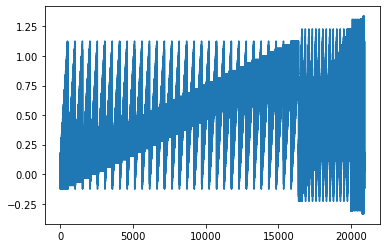

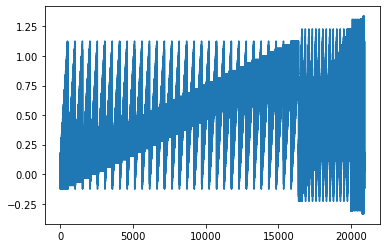

0.9929759174311926
float32
float32


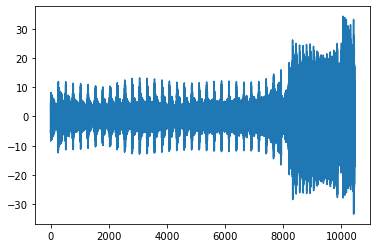

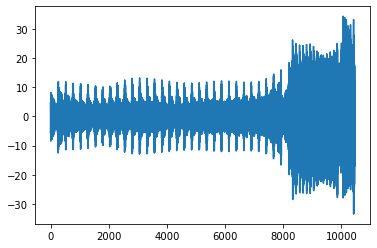

0.0
float32
float32


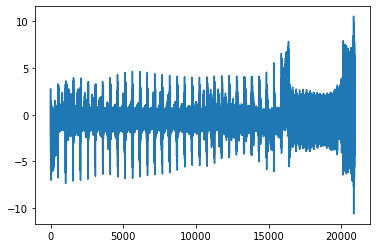

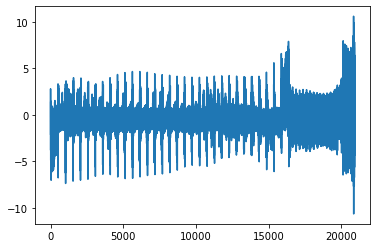

0.0


In [76]:
model_ssd.eval()
tranfer_params(model_tf, model_ssd, 256,256,3, 1)